In [2]:
# --- Inicializa entorno de imports ---
import sys, pathlib

# Calcula la ruta a la carpeta donde está "src"
#   • Si tu notebook vive en /proyecto/notebooks/, subimos un nivel
root = (pathlib.Path.cwd().parent)  # ajusta si mueves el notebook

if str(root) not in sys.path:
    sys.path.append(str(root))

# ───────────────────────────────────────────────────────────────
# 1. IMPORTS
# ───────────────────────────────────────────────────────────────

from keras.models import load_model                       # Keras 3
from src.metricas.metrics   import fuzzy_accuracy_tf, fpi
from src.neurofuzzy.model   import FuzzLayer              # importa la capa
from src.utils.preprocessing import load_data, ROOT
from src.baseline.random_forest import load_rf
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np, pathlib
import tensorflow as tf

from joblib import load
import pandas as pd

[preprocessing]  ROOT = C:\fuzzy_calidad_agua
[preprocessing]  DATA.exists?  True


In [3]:
# Modelo RANDOM FOREST
# ── 1. asegura que Python ve la carpeta raíz ───────────────────
import sys, pathlib, importlib
root = pathlib.Path.cwd().parent          # notebooks → fuzzy_calidad_agua
if str(root) not in sys.path:
    sys.path.append(str(root))

# ── 2. recarga el módulo para coger la versión nueva ───────────
import src.baseline.random_forest as rf_mod
importlib.reload(rf_mod)

from src.baseline.random_forest import train_rf, load_rf
from src.utils.preprocessing import load_data, ROOT

In [4]:
# ───────────────────────────────────────────────────────────────
# 3. DATOS
# ───────────────────────────────────────────────────────────────
X_tr, X_ts, y_tr, y_ts = load_data()       # y_ts son enteros 0/1/2

In [5]:
# ── 4. entrena y GUARDA en notebooks/models/rf.pkl ---------------
rf = train_rf(X_tr, y_tr)      # usa la ruta DEFAULT_PATH nueva
print("Guardado en:", rf_mod.DEFAULT_PATH.resolve())

Guardado en: C:\fuzzy_calidad_agua\notebooks\models\rf.pkl


### Modelo ANFIS (FORMATO .KERAS)

In [6]:
# ───────────────────────────────────────────────────────────────
# 5. CARGAR ANFIS  (formato .keras)
# ───────────────────────────────────────────────────────────────
anfis_path = ROOT / "models" / "anfis_tf.keras"
anfis = load_model(
    anfis_path,
    custom_objects={
        "FuzzLayer": FuzzLayer,            # ← añadido
        "fuzzy_accuracy_tf": fuzzy_accuracy_tf,
        "fpi": fpi
    }
)


In [7]:
# Predicciones
y_prob_anfis = anfis.predict([X_ts[:, i] for i in range(X_ts.shape[1])])
y_hat_anfis  = y_prob_anfis.argmax(axis=1)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [8]:
# ───────────────────────────────────────────────────────────────
# 4. CARGAR RANDOM FOREST
# ───────────────────────────────────────────────────────────────
rf = load_rf("models/rf.pkl")
y_hat_rf = rf.predict(X_ts)

In [9]:
# ───────────────────────────────────────────────────────────────
# 5. REPORTE DE DESEMPEÑO
# ───────────────────────────────────────────────────────────────
print("=== ANFIS (.keras) ===")
print(classification_report(y_ts, y_hat_anfis, target_names=["Pobre","Bueno","Excelente"]))
print("=== Random Forest ===")
print(classification_report(y_ts, y_hat_rf,   target_names=["Pobre","Bueno","Excelente"]))

=== ANFIS (.keras) ===
              precision    recall  f1-score   support

       Pobre       0.95      1.00      0.98       280
       Bueno       0.95      0.99      0.97       280
   Excelente       0.99      0.91      0.95       300

    accuracy                           0.97       860
   macro avg       0.97      0.97      0.97       860
weighted avg       0.97      0.97      0.96       860

=== Random Forest ===
              precision    recall  f1-score   support

       Pobre       0.99      1.00      1.00       280
       Bueno       0.99      1.00      0.99       280
   Excelente       1.00      0.98      0.99       300

    accuracy                           0.99       860
   macro avg       0.99      0.99      0.99       860
weighted avg       0.99      0.99      0.99       860



In [12]:
# 0) Importa las utilidades necesarias
from src.baseline.random_forest import load_rf
from src.utils.preprocessing import load_data

# 1) Carga tus datos (tal como lo hace train.py)
#    load_data debería devolver X_tr, X_ts, y_tr_int, y_ts_int
_, X_ts, _, y_ts_int = load_data()

# 2) Carga el RF desde el .pkl serializado
rf_model = load_rf()  # usa DEFAULT_PATH = .../notebooks/models/rf.pkl

# 3) Ahora evalúas sin NameError:
rf_preds = rf_model.predict(X_ts)
print("=== Random Forest ===")
print(f"RMSE:           {rmse(y_ts_int, rf_preds):.4f}")
print(f"Accuracy:       {np.mean(rf_preds == y_ts_int):.4f}")
print(f"Fuzzy Accuracy: {fuzzy_accuracy(y_ts_int, rf_preds):.4f}")
print(f"FPI:            {fpi(y_ts_int, rf_preds):.4f}")


=== Random Forest ===
RMSE:           0.1181
Accuracy:       0.9930
Fuzzy Accuracy: 0.9977
FPI:            0.9953


In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# -------------------------------------------------------------------
# 1) Define las funciones de evaluación
# -------------------------------------------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def fuzzy_accuracy(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) <= 1)

def fpi(y_true, y_pred, weights=(1.0, 0.5, 0.0)):
    d = np.abs(y_true - y_pred)
    w = np.array(weights, dtype=float)
    return np.mean(w[d])

# -------------------------------------------------------------------
# 2) Evalúa el Random Forest
# -------------------------------------------------------------------
# Asegúrate de que rf_model y X_ts, y_ts_int estén definidos en tu notebook
rf_preds = rf_model.predict(X_ts)            # Enteros 0,1,2
print("=== Random Forest ===")
print(f"RMSE:           {rmse(y_ts_int, rf_preds):.4f}")
print(f"Accuracy:       {np.mean(rf_preds == y_ts_int):.4f}")
print(f"Fuzzy Accuracy: {fuzzy_accuracy(y_ts_int, rf_preds):.4f}")
print(f"FPI:            {fpi(y_ts_int, rf_preds):.4f}")

# -------------------------------------------------------------------
# 3) Evalúa el ANFIS
# -------------------------------------------------------------------
# Para ANFIS se alimenta como lista de arrays: uno por variable
# X_ts tiene forma (n_samples, 13)
anfis_inputs = [X_ts[:, i] for i in range(X_ts.shape[1])]
# Predicciones softmax (n_samples, 3)
y_proba = anfis.predict(anfis_inputs)
# Convertir a enteros 0,1,2
anfis_preds = np.argmax(y_proba, axis=1)

print("\n=== ANFIS ===")
print(f"RMSE:           {rmse(y_ts_int, anfis_preds):.4f}")
print(f"Accuracy:       {np.mean(anfis_preds == y_ts_int):.4f}")
print(f"Fuzzy Accuracy: {fuzzy_accuracy(y_ts_int, anfis_preds):.4f}")
print(f"FPI:            {fpi(y_ts_int, anfis_preds):.4f}")



=== Random Forest ===
RMSE:           0.1181
Accuracy:       0.9930
Fuzzy Accuracy: 0.9977
FPI:            0.9953
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

=== ANFIS ===
RMSE:           0.2893
Accuracy:       0.9651
Fuzzy Accuracy: 0.9837
FPI:            0.9744


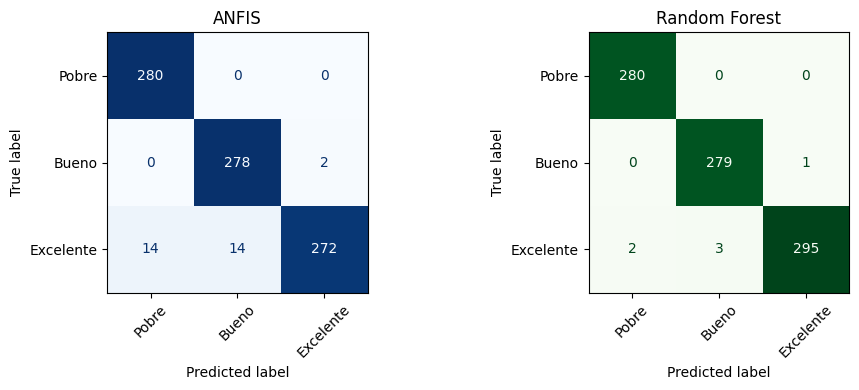

In [ ]:
# ───────────────────────────────────────────────────────────────
# 6. MATRICES DE CONFUSIÓN (opcional)
# ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(
    y_ts, y_hat_anfis, display_labels=["Pobre","Bueno","Excelente"],
    cmap="Blues", ax=axes[0], colorbar=False, normalize=None, xticks_rotation=45
)
axes[0].set_title("ANFIS")

ConfusionMatrixDisplay.from_predictions(
    y_ts, y_hat_rf, display_labels=["Pobre","Bueno","Excelente"],
    cmap="Greens", ax=axes[1], colorbar=False, normalize=None, xticks_rotation=45
)
axes[1].set_title("Random Forest")

plt.tight_layout()
plt.show()


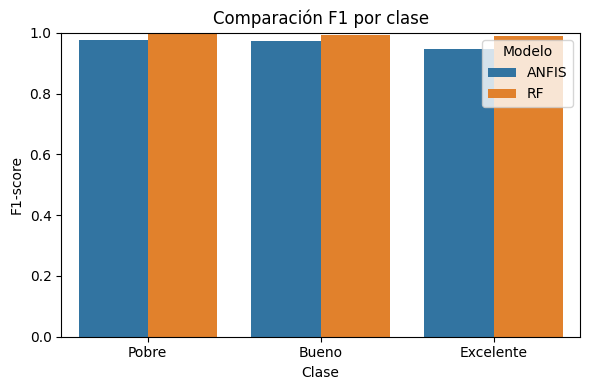

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ─────────────────────────────────────────────────────────────
# 1.  F-scores por clase
# ─────────────────────────────────────────────────────────────
#   y_ts        → etiquetas reales   (array 0/1/2)
#   y_hat_anfis → predicciones ANFIS
#   y_hat_rf    → predicciones RF

# Devuelve (precision, recall, f1, support); average=None ⇒ por clase
_, _, f1_an_per_class, _ = precision_recall_fscore_support(
    y_ts, y_hat_anfis, average=None, labels=[0,1,2]
)
_, _, f1_rf_per_class, _ = precision_recall_fscore_support(
    y_ts, y_hat_rf, average=None, labels=[0,1,2]
)

# ─────────────────────────────────────────────────────────────
# 2.  DataFrame para graficar
# ─────────────────────────────────────────────────────────────
clases = ["Pobre", "Bueno", "Excelente"]
f1_df = pd.DataFrame({
    "Clase": clases,
    "ANFIS": f1_an_per_class,
    "RF":    f1_rf_per_class
}).melt(id_vars="Clase", var_name="Modelo", value_name="F1")

# ─────────────────────────────────────────────────────────────
# 3.  Gráfico (Seaborn -> barras agrupadas)
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
sns.barplot(data=f1_df, x="Clase", y="F1", hue="Modelo")
plt.ylim(0,1)
plt.ylabel("F1-score")
plt.title("Comparación F1 por clase")
plt.tight_layout()
plt.show()


### Comparación de curva ROC

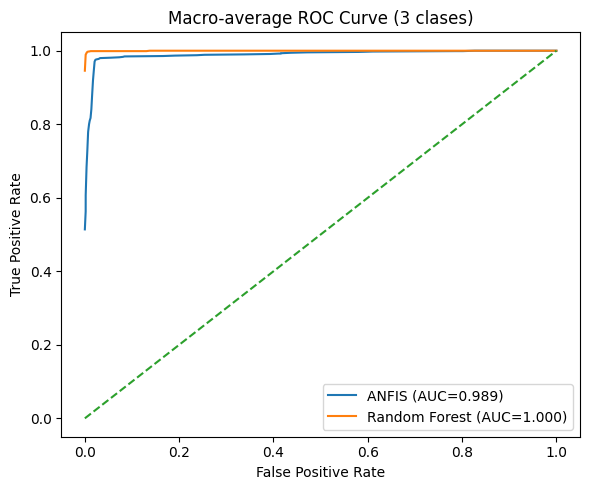

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# -----------------------------------------------------------------
# Asegúrate de tener en memoria:
#   - y_ts            (vector de enteros 0/1/2)
#   - y_prob_anfis    (matriz n×3 de probabilidades ANFIS)
#   - X_ts, rf        (para generar y_prob_rf = rf.predict_proba(X_ts))
# -----------------------------------------------------------------

y_true  = np.asarray(y_ts, dtype=np.int32)
prob_an = np.asarray(y_prob_anfis, dtype=float)
prob_rf = rf.predict_proba(X_ts)

# Binarizar etiquetas para ROC multiclass
y_bin = label_binarize(y_true, classes=[0,1,2])
n_classes = y_bin.shape[1]

def macro_roc(y_bin, y_score):
    fpr, tpr, aucs = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        aucs[i] = auc(fpr[i], tpr[i])

    # Macro-average
    all_fpr  = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    auc_macro = auc(all_fpr, mean_tpr)
    return all_fpr, mean_tpr, auc_macro

fpr_an, tpr_an, auc_an = macro_roc(y_bin, prob_an)
fpr_rf, tpr_rf, auc_rf = macro_roc(y_bin, prob_rf)

# ---------------- Gráfico -----------------
plt.figure(figsize=(6,5))
plt.plot(fpr_an, tpr_an, label=f"ANFIS (AUC={auc_an:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-average ROC Curve (3 clases)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### Análisis de Fuzzy accuracy y FPI

In [ ]:
y_true_tf = tf.constant(y_ts,        dtype=tf.int32)
y_pred_tf = tf.constant(y_hat_anfis, dtype=tf.int32)

fa_tf  = tf.reduce_mean(tf.cast(tf.abs(y_true_tf - y_pred_tf) <= 1, tf.float32))
fpi_tf = tf.reduce_mean(
            tf.where(tf.equal(y_true_tf, y_pred_tf), 0.0,
                tf.where(tf.abs(y_true_tf - y_pred_tf) == 1, 0.5, 1.0))
         )

print("Fuzzy accuracy:", fa_tf.numpy())
print("FPI           :", fpi_tf.numpy())



Fuzzy accuracy: 0.98372096
FPI           : 0.025581395


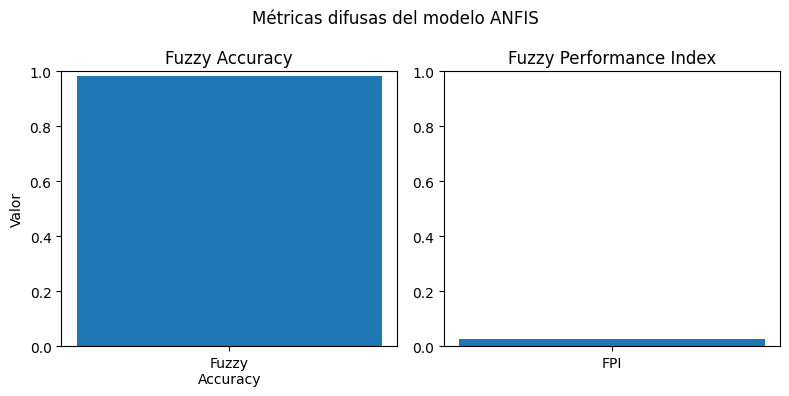

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- métricas ---------------------------------------------------------
y_true = np.asarray(y_ts, dtype=np.int32)
y_pred = np.asarray(y_hat_anfis, dtype=np.int32)

dist        = np.abs(y_true - y_pred)
fuzzy_acc   = np.mean(dist <= 1)
fpi_val     = np.mean(np.where(dist == 0, 0,
                        np.where(dist == 1, 0.5, 1)))

# --- gráfico ----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].bar(["Fuzzy\nAccuracy"], [fuzzy_acc])
axes[0].set_ylim(0, 1)
axes[0].set_title("Fuzzy Accuracy")
axes[0].set_ylabel("Valor")

axes[1].bar(["FPI"], [fpi_val])
axes[1].set_ylim(0, 1)
axes[1].set_title("Fuzzy Performance Index")

plt.suptitle("Métricas difusas del modelo ANFIS")
plt.tight_layout()
plt.show()


### Curva ROC y AUC (micro y macro)

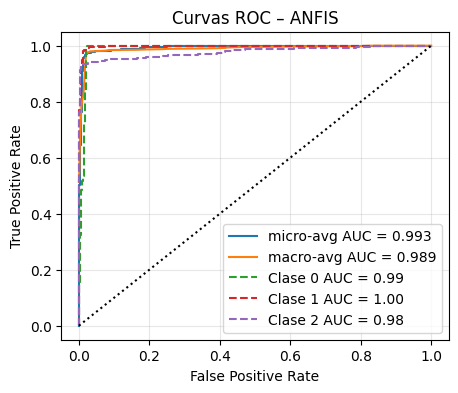

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

classes = [0, 1, 2]                     # etiquetas de tus tres clases
y_bin   = label_binarize(y_ts, classes=classes)   # ← parámetro por nombre

fpr = {}; tpr = {}; roc_auc = {}
for i, c in enumerate(classes):
    fpr[c], tpr[c], _ = roc_curve(y_bin[:, i], y_prob_anfis[:, i])
    roc_auc[c] = auc(fpr[c], tpr[c])

# micro- y macro-promedio
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_prob_anfis.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)
for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-avg AUC = {roc_auc['micro']:.3f}")
plt.plot(all_fpr,  mean_tpr,
         label=f"macro-avg AUC = {roc_auc['macro']:.3f}")
for c in classes:
    plt.plot(fpr[c], tpr[c], linestyle="--",
             label=f"Clase {c} AUC = {roc_auc[c]:.2f}")
plt.plot([0,1], [0,1], "k:")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Curvas ROC – ANFIS")
plt.legend(); plt.grid(alpha=.3)
plt.show()



## Curvas Precision - Recall

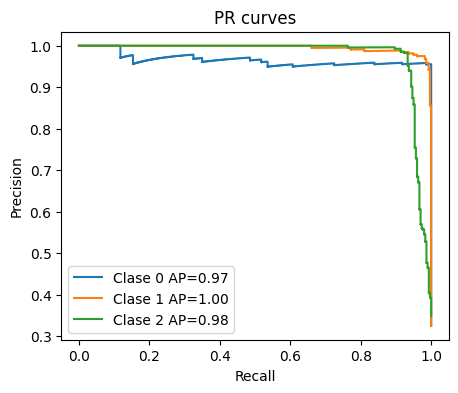

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(5,4))
for i,c in enumerate(classes):
    prec, rec, _ = precision_recall_curve(y_bin[:,i], y_prob_anfis[:,i])
    ap = average_precision_score(y_bin[:,i], y_prob_anfis[:,i])
    plt.step(rec, prec, where="post", label=f"Clase {c} AP={ap:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.title("PR curves")
plt.show()


### Gráfico de calibración

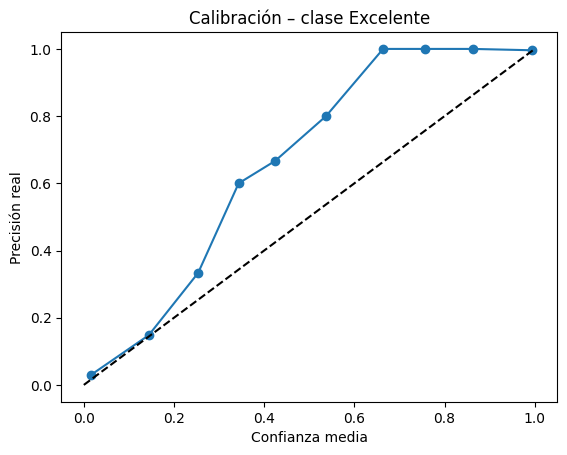

In [ ]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_bin[:,2], y_prob_anfis[:,2], n_bins=10)
plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],"k--")
plt.xlabel("Confianza media"); plt.ylabel("Precisión real"); plt.title("Calibración – clase Excelente")
plt.show()


### Error Analysis Table (falso positivos/negativos)

In [ ]:
import pandas as pd
errors = pd.DataFrame({"true": y_ts, "pred": y_hat_anfis})
display(errors[(errors.true==2) & (errors.pred!=2)].head())   # ejemplos falsos negativos


,true,pred
29,2,1
39,2,0
57,2,1
65,2,0
124,2,1


## Inspección de la red ANFIS
### Red tabular

In [ ]:
anfis.summary(line_length=120)

Model: "ANFIS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ x0 (InputLayer)                   │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x1 (InputLayer)                   │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x2 (InputLayer)                   │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x3 (InputLayer)                   │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x4 (InputLayer)                   │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x5 (InputLayer)                   │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x6 (InputLayer)                   │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x7 (InputLayer)                   │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x8 (InputLayer)                   │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x9 (InputLayer)                   │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x10 (InputLayer)                  │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x11 (InputLayer)                  │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ x12 (InputLayer)                  │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ fuzz0 (FuzzLayer)                 │ (None, 1, 3)                 │                12 │ x0[0][0]                  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ fuzz1 (FuzzLayer)                 │ (None, 1, 3)                 │                12 │ x1[0][0]                  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ fuzz2 (FuzzLayer)                 │ (None, 1, 3)                 │                12 │ x2[0][0]                  
├───────────────────────────────────┼───────────────────

 Total params: 4,799 (18.75 KB)

 Trainable params: 1,599 (6.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,200 (12.50 KB)

### Ver los vértices finales de cada MF

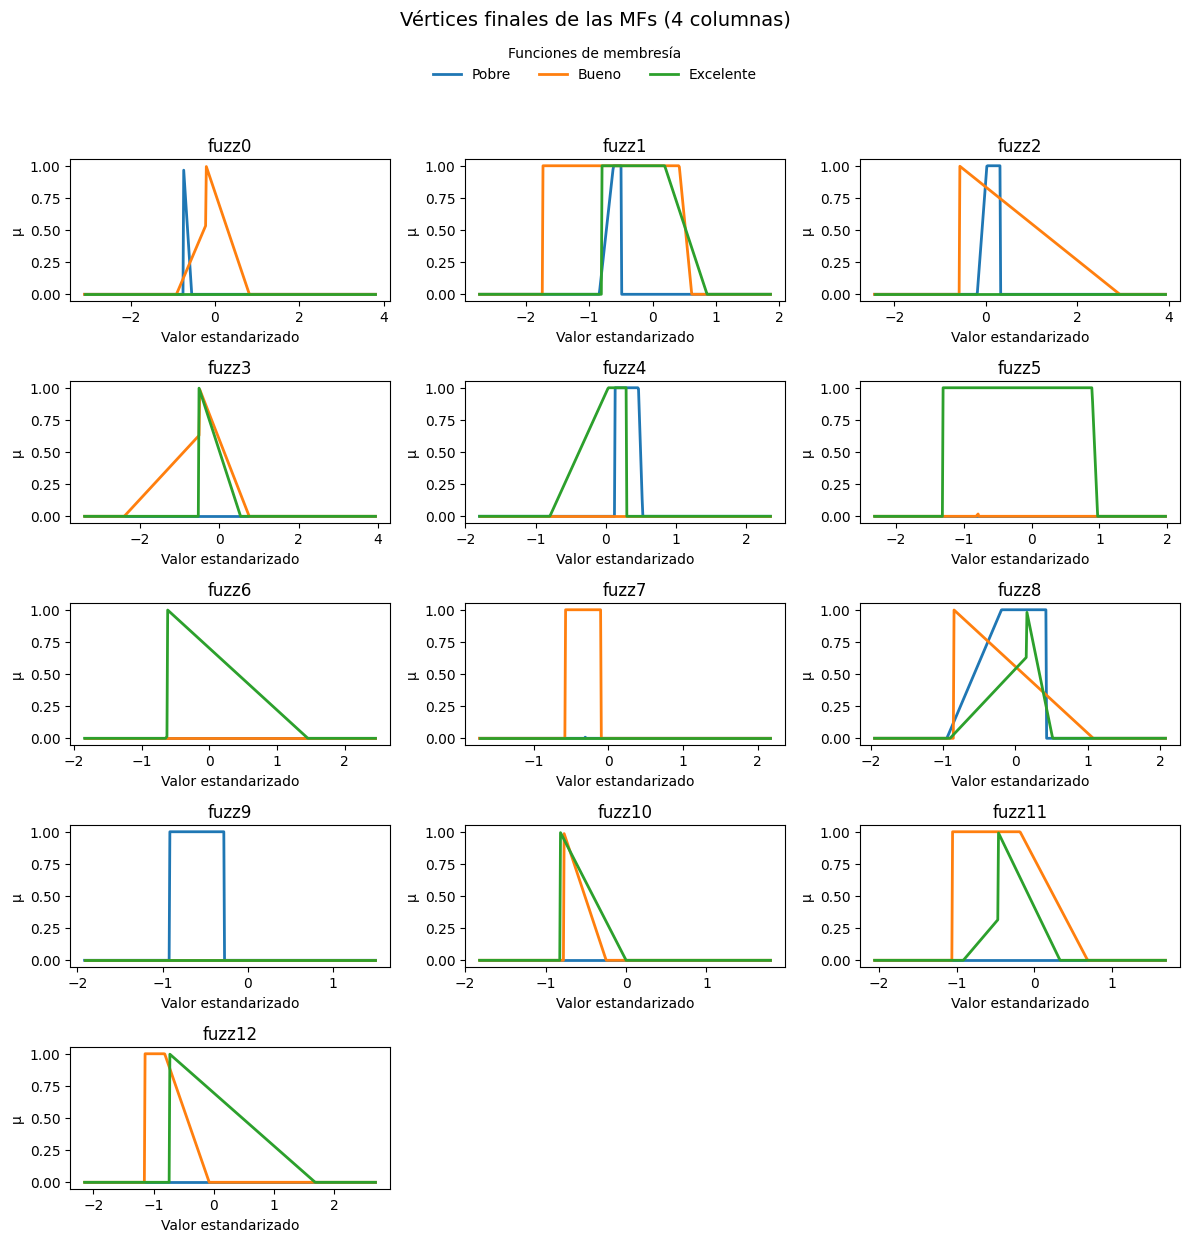

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Layer

# … aquí va tu stub de FuzzLayer y la carga del modelo …

# Extrae vértices
mfs = [(ly.name, ly.p.numpy())
       for ly in anfis.layers if isinstance(ly, FuzzLayer)]

# Prepara grid
n_vars = len(mfs)
cols   = 3
rows   = int(np.ceil(n_vars / cols))
fig, axes = plt.subplots(rows, cols,
                         figsize=(cols * 4, rows * 2.5))
axes = axes.flatten()

# Dibuja subplots
colors = ["C0","C1","C2"]
for idx, (name, verts) in enumerate(mfs):
    ax = axes[idx]
    xs = np.linspace(verts.min()-1, verts.max()+1, 400)
    for i, (a,b,c,d) in enumerate(verts):
        ys = np.piecewise(xs,
            [xs < a,
             (xs >= a)&(xs < b),
             (xs >= b)&(xs < c),
             (xs >= c)&(xs < d),
             xs >= d],
            [0,
             lambda x, a=a, b=b: (x-a)/(b-a+1e-9),
             1,
             lambda x, c=c, d=d: (d-x)/(d-c+1e-9),
             0])
        ax.plot(xs, ys, color=colors[i], lw=2)
    ax.set_title(name)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Valor estandarizado")
    ax.set_ylabel("μ")

# Quita ejes vacíos
for j in range(n_vars, rows*cols):
    fig.delaxes(axes[j])

# Reserva espacio arriba para leyenda y título
fig.tight_layout(rect=[0, 0, 1, 0.90])  
#   → [left, bottom, right, top]  
#      deja libre el 10% superior

# Leyenda global justo arriba de los subplots
from matplotlib.lines import Line2D
handles = [Line2D([0],[0], color=colors[i], lw=2) for i in range(3)]
labels  = ["Pobre","Bueno","Excelente"]
fig.legend(handles, labels,
           title="Funciones de membresía",
           loc="upper center",
           bbox_to_anchor=(0.5, 0.97),
           ncol=3,
           frameon=False)

# Título general
fig.suptitle("Vértices finales de las MFs (4 columnas)", y=0.99, fontsize=14)

plt.show()



1. Desplazamiento según la densidad de datos
La MF “Bueno” (naranja) en la mayoría de variables está centrada en torno a 0 (la media tras el escalado), lo que significa que ANFIS ha aprendido que la mayor parte de los datos —independientemente de su clase— se concentra en esa zona.

Las MF “Pobre” (azul) aparecen desplazadas hacia valores negativos (–1σ o menos) y las MF “Excelente” (verde) hacia valores positivos (+1σ o más), adaptándose al sesgo de cada feature.

2. Solapes moderados = transiciones suaves
Variables como fuzz1, fuzz2 y fuzz3 presentan buenos solapes entre “Pobre”→“Bueno” y “Bueno”→“Excelente”, evitando fronteras duras.

Esto le da al modelo capacidad de generalizar mejor en rangos intermedios, reflejando la continuidad de la calidad del agua.

3. Colapso de una MF → señal de información escasa
En fuzz0, fuzz5, fuzz7, fuzz9 (y en cierta medida fuzz12), la MF “Excelente” o “Pobre” aparece plana (μ=0 en todo el rango).

Indica que ANFIS ha decidido que solo dos categorías resultan relevantes para esa variable; la tercera no aporta poder discriminativo.

4. Anchura de trapecios = variabilidad dentro de la clase
MF muy estrechas (p.ej. la MF “Bueno” en fuzz7) sugieren un umbral muy estricto —riesgo de sobreajuste en esa dimensión—.

MF muy anchas (p.ej. la MF “Bueno” en fuzz1) implican que esa variable apenas separa clases y podría tener bajo peso en la capa de reglas.

5. Implicaciones prácticas
Variables con MF colapsadas podrían reducirse a 2 MFs y ahorrar complejidad.

Ajusta manualmente los vértices de aquellas MFs demasiado angostas o demasiado anchas para afinar el comportamiento en las colas de la distribución.

Tras cada ajuste vuelve a graficar y comprueba que los trapecios sigan teniendo sentido físico (pH en rangos razonables, temperaturas dentro de lo posible, etc.).

En resumen, estas gráficas te muestran cómo ANFIS ha reconfigurado los umbrales normativos iniciales a base de la distribución real de tus datos, optimizando las tres categorías “Pobre–Bueno–Excelente” en cada variable. Donde veas una MF plana o excesivamente estrecha/ancha, ya sabes que esa dimensión podría requerir un refinamiento manual o un ajuste de hiperparámetros (número de MFs, pesos de clase, etc.) para mejorar su capacidad discriminativa.